# Using with `pyspark` for data preprocessing

We want to use pyspark to preprocess a potentially huge dataset used for
web-marketing.

## Data description

The data is a `parquet` file which contains a dataframe with 8 columns:

-   `xid`: unique user id
-   `action`: type of action. ‘C’ is a click, ‘O’ or ‘VSL’ is a
    web-display
-   `date`: date of the action
-   `website_id`: unique id of the website
-   `url`: url of the webpage
-   `category_id`: id of the display
-   `zipcode`: postal zipcode of the user
-   `device`: type of device used by the user

> **Questions**
>
> -   According to you, how was that data asset collected?
> -   In the likely context (digital marketing), what is a *web
>     display*?
> -   What are the different values of `category_id`? What are their
>     respective frequencies?
> -   What are the 10 most frequent websites (according to the data)?
> -   What are the different devices used across the dataset?
> -   When was the dataset collected?

## Q1. Some statistics / computations

Using `pyspark.sql`, we want to do the following things:

1.  Compute the total number of unique users
2.  Construct a column containing the total number of actions per user
3.  Construct a column containing the number of days since the last
    action of the user
4.  Construct a column containing the number of actions of each user for
    each modality of device

## Q2. Binary classification

Then, we want to construct a *classifier* to predict the click on
category 1204 (`category_id`).

Here is an agenda for this:

1.  Construction of a *feature matrix* where each line gathers
    information about a single user (identified by `xid`).
2.  In the *feature matrix*, we need to keep only the rows (users)
    reporting exposition to the display in category 1204
3.  Using this *training* dataset, *train* a *binary classifier*, and
    evaluate the classifier using a *precision/recall* curve computed on
    test data.

> **Note**
>
> Viewing this dataset and the task at hand, we might be tempted to just
> filter rows satisfying condition `category_id=='1204'`, and fit a
> model that predict `action` given the other columns (or given some of
> them). This is not what the agenda suggests. Why?

# Download/read the data and have a look

## Round up the usual suspects

In [1]:
import os
import sys
import requests, zipfile, io

from time import perf_counter
# from pathlib import Path

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [4]:
from pyspark.sql import Window
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit

In [5]:
from functools import reduce
import numpy as np
from scipy.sparse import csr_matrix

The next imports are used at the end of the notebook.

In [6]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

## Set up the spark client

> **Note**
>
> As we are not interacting with a preexisting cluster, we actually need
> to start a server and a client. So far, we used the `local` mode. Even
> with a laptop/desktop, several modes are available
>
> -   `local`
> -   `standalone`
> -   

> **Spark in standalone mode**
>
> To launch spark in `standalone` mode, assuming the current working
> directory is `$SPARK_HOME`
>
> Assume that `hadoop` is running. This can be checked by monitoring
> java processes running on the local machine
>
> ``` jps
> $ jps 
> 30033 Jps
> >>> 18898 NodeManager
> >>> 17735 NameNode
> >>> 18216 SecondaryNameNode
> >>> 17965 DataNode
> >>> 18542 ResourceManager
> ```
>
> `NameNode` `DataNode` and `SecondaryNameNode` have been launched by
> `start-dfs.sh`, while `NodeManager` and `ResourceManager` have been
> launched by `start-yarn`.
>
> We can monitor `NameNode` at `http://localhost:9870`
>
> Then we may launch a `master` and a `worker` process.
>
> ``` bash
> $ ./sbin/start-master.sh --ip localhost
> >>> starting org.apache.spark.deploy.master.Master, logging to ...
> $ ./sbin/start-worker.sh spark://localhost:7077
> ```
>
> We may now launch the instance of `SparkSession`, setting explicitly
> the `master` node and the port to communicate with the `master`.
>
> ``` python
> # spark =  (
> #     SparkSession.builder 
> #             .appName("Spark webdata") 
> #             .master("spark://localhost:7077") 
> #             .config("spark.driver.memory", "16G") 
> #             .config("spark.driver.maxResultSize", "0") 
> #             .getOrCreate()
> # )
> ```
>
> SparkUI should be reachable at `localhost:4040`.
>
> The `master` can be monitored at `localhost:8080`

In [8]:
spark = (
    SparkSession
        .builder
        .appName("Taming Webdata")
        .config("spark.driver.memory", "16G") 
        .config("spark.driver.maxResultSize", "0")
        .getOrCreate()
)

sc = spark._sc

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/16 10:09:06 WARN Utils: Your hostname, boucheron-Precision-5480, resolves to a loopback address: 127.0.1.1; using 172.23.32.10 instead (on interface eth0)
26/02/16 10:09:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/16 10:09:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

### Prepare for `checkpointing`

> **Note**
>
> Handling this modest dataset will put our Spark server under strain.
> To make our life easier, we should prepare for caching and
> checkpointing.

In [9]:
(
    spark.sparkContext.setCheckpointDir("file://"+ os.getcwd())
)

### Downloading dataset (if needed)

In [10]:
path = './data/webdata.parquet'

In [11]:
if not os.path.exists(path):
    url = "https://s-v-b.github.io/IFEBY310/data/webdata.parquet.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='./data/')

The default file system used by the spark object may be the local
filesystem or hdfs. We explicitly ask for using the local filesystem.

In [12]:
file_path = 'file://' + os.path.abspath(path)

df = spark.read.parquet(file_path)

> **Note**
>
> Have a look at [Spark UI](http://localhost:4040/jobs/). Did the
> preceding chunk trigger an action? If yes, how many stages? tasks?
>
> Try
>
> ``` python
> !tree -L 1 data/webdata.parquet/ 
> ```
>
> to check wether the parquet file is partitioned. Check wether the
> different partitions are read concurrently.

# Let us select the correct users and build a training dataset

We construct a ETL (Extract Transform Load) process on this data using
the `pyspark.sql` API.

> **Note**
>
> ETL (Extract Transform Load) and ELT (Extract Load Transform). Check
> that you understand these two acronyms. What do they stand for? What
> is the difference?

## Extraction

Here *extraction* is just about reading the data.

> **Note**
>
> What else coud *extraction* be about?

In [13]:
df.show(n=3)

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|001ff9b6-5383-422...|     O|2017-01-25 07:02:18|         3|http://www.8chanc...|     1002.0|  11370|   SMP|
|0056ab7a-3cba-4ed...|     O|2016-12-28 09:47:08|        54|http://www.salair...|     1002.0|  86000|   DSK|
|005ae4ab-363a-41a...|     O|2017-01-27 22:21:06|        74|http://www.realit...|     1002.0|  49700|   DSK|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
only showing top 3 rows

> **Note**
>
> How many stages and tasks did action `show()` triggered?
>
> Look at the plan details in tab SQL/Dataframe on [Spark
> UI](http://localhost:4040/jobs/). What are the different steps? Is
> there any shuffle?

Much of our work will consist in computing `window` functions over
windows defined by a partition over `xid` (users). This comes from the
fact that most of our features will be built by inspecting the events
related with a given user (`xid`). Computing window functions over
partitions is likely to trigger shuffles.

In [14]:
df = df.repartition(20, 'xid')

> **Note**
>
> Is repartition an action or a transformation?

In [15]:
df.cache()

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string]

In [16]:
# sc.setCheckpointDir("file://" + os.path.abspath(os.path.curdir))   

df.checkpoint()

[Stage 2:=================================>                        (7 + 5) / 12][Stage 4:>                                                        (0 + 20) / 20]                                                                                

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string]

> **Questions**
>
> -   What does `checkpoint()` actually do?
> -   Is it different from `df.cache()`?
> -   How many jobs did `checkpoint()` trigger?
> -   Did `checkpoint()` trigger writing in checkpoint directory?

The dataframe `df` has been repartitioned in 20 partitions along column
`xid`. Let us check that the number of distinct values of `xid` is
balanced.

In [17]:
df.explain()

> **Note**
>
> Evaluate the preceding chunk. How do the final and initial compare?
> Identify shuffle stages?

In [18]:
def foo(x): yield len(set(x))

n_xid_per_partitions = ( 
    df.rdd
    .map(lambda x : x.xid)
    .mapPartitions(foo)
    .collect()
)

[Stage 8:>                                                        (0 + 20) / 20][Stage 8:==>                                                      (1 + 19) / 20][Stage 8:============================>                           (10 + 10) / 20]                                                                                

> **Note**
>
> `yield` is a Python keyword that indicates that `foo` is a function
> *generator*. Try `foo(range(10))` and then `next(foo(range(10)))` and
> finally
>
> ``` python
> bar = foo(range(10))
> next(bar)
> next(bar)
> ```
>
> to guess what this means.
>
> -   Read the documentation of `mapPartitions()`
> -   Read chapter `Iterators, Generators, ...` in [Fluent
>     Python](https://www.oreilly.com/library/view/fluent-python-2nd/9781492056348/)

In the sequel, we may query dataframe `df` using `spark.sql()`. To make
this possible, we have to register the dataframe as a temporary view.

In [19]:
spark.sql("SHOW TABLES ;").show()

df.createOrReplaceTempView("webdata")

spark.sql("SHOW TABLES ;").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         |  webdata|       true|
+---------+---------+-----------+


In [20]:
spark.sql("DESC EXTENDED webdata ;").show()

+-----------+---------+-------+
|   col_name|data_type|comment|
+-----------+---------+-------+
|        xid|   string|   NULL|
|     action|   string|   NULL|
|       date|timestamp|   NULL|
| website_id|   string|   NULL|
|        url|   string|   NULL|
|category_id|    float|   NULL|
|    zipcode|   string|   NULL|
|     device|   string|   NULL|
+-----------+---------+-------+


> **Note**
>
> When handling managed tables (not views) and combined with
> `ANALYZE TABLE`, `DESC EXTENDED` can provide precious information on
> column statistics.

## Transformation of the data

At this step we compute a lot of extra things from the data. The aim is
to build *features* that describe users. The features will eventually be
used by ML (Machine Learning) methods.

Each feature is built by feeding a *transformer* with a dataframe. Each
transformer returns a dataframe with one more column.

The prospective list of transformers is:

    hour_transformer
    weekday_transformer
    n_actions_per_category_id_transformer
    n_days_since_last_action_transformer
    n_days_since_last_event_transformer
    n_events_per_category_id_transformer
    n_events_per_device_transformer
    n_events_per_hour_transformer
    n_events_per_website_id_transformer
    n_events_per_weekday_transformer
    n_unique_day_transformer
    n_unique_device_transformer
    n_unique_hour_transformer

Each transformer (besides `hour_transformer` and
`weekday_transformer`)is defined by

-   a `Window` object (optional, some are used several times),
-   a column function that defines the added column, and
-   a name for the added column.

The transformer is named after the name of the added column. All
transformers have the same signature.

In [21]:
def hour_transformer(df):
    hour = func.hour(col('date'))
    df = df.withColumn('hour', hour)
    return df

def weekday_transformer(df):
    weekday = func.date_format(col('date'), 'EEEE')
    df = df.withColumn('weekday', weekday)
    return df

In [22]:
def n_events_transformer(df):
    xid_partition = Window.partitionBy('xid')
    n_events = func.count(col('action')).over(xid_partition)
    
    df = df.withColumn('n_events', n_events)

    return df

def n_events_per_action_transformer(df):
    xid_action_partition = Window.partitionBy('xid', 'action')
    n_events_per_action = func.count(col('action')).over(xid_action_partition)

    df = df.withColumn('n_events_per_action', n_events_per_action)
    
    return df



def n_events_per_hour_transformer(df):
    xid_hour_partition = Window.partitionBy('xid', 'hour')
    n_events_per_hour = (
        func.count(col('action')).over(xid_hour_partition)
    )
    df = df.withColumn('n_events_per_hour', n_events_per_hour)
    return df

def n_events_per_weekday_transformer(df):
    xid_weekday_partition = Window.partitionBy('xid', 'weekday')
    n_events_per_weekday = func.count(col('action')).over(xid_weekday_partition)
    df = df.withColumn('n_events_per_weekday', n_events_per_weekday)
    return df

def n_days_since_last_event_transformer(df):
    xid_partition = Window.partitionBy('xid')
    max_date = func.max(col('date')).over(xid_partition)
    n_days_since_last_event = func.datediff(func.current_date(), max_date)
    df = df.withColumn('n_days_since_last_event',
                       n_days_since_last_event + lit(0.1))
    return df

def n_days_since_last_action_transformer(df):
    xid_partition_action = Window.partitionBy('xid', 'action')
    max_date = func.max(col('date')).over(xid_partition_action)
    n_days_since_last_action = func.datediff(func.current_date(),
                                                        max_date)
    df = df.withColumn('n_days_since_last_action',
                       n_days_since_last_action + lit(0.1))
    return df

def n_unique_day_transformer(df):
    xid_partition = Window.partitionBy('xid')
    dayofyear = func.dayofyear(col('date'))
    rank_day = func.dense_rank().over(xid_partition.orderBy(dayofyear))
    n_unique_day = func.last(rank_day).over(xid_partition)
    df = df.withColumn('n_unique_day', n_unique_day)
    return df

def n_unique_hour_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_hour = func.dense_rank().over(xid_partition.orderBy('hour'))
    n_unique_hour = func.last(rank_hour).over(xid_partition)
    df = df.withColumn('n_unique_hour', n_unique_hour)
    return df

def n_events_per_device_transformer(df):
    xid_device_partition = Window.partitionBy('xid', 'device')
    n_events_per_device = func.count(func.col('device')) \
        .over(xid_device_partition)
    df = df.withColumn('n_events_per_device', n_events_per_device)
    return df

def n_unique_device_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_device = func.dense_rank().over(xid_partition.orderBy('device'))
    n_unique_device = func.last(rank_device).over(xid_partition)
    df = df.withColumn('n_device', n_unique_device)
    return df

def n_actions_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id',
                                                   'action')
    n_actions_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_actions_per_category_id', n_actions_per_category_id)
    return df

def n_unique_category_id_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_category_id = func.dense_rank().over(xid_partition\
                                              .orderBy('category_id'))
    n_unique_category_id = func.last(rank_category_id).over(xid_partition)
    df = df.withColumn('n_unique_category_id', n_unique_category_id)
    return df

def n_events_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id')
    n_events_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_events_per_category_id', n_events_per_category_id)
    return df

def n_events_per_website_id_transformer(df):
    xid_website_id_partition = Window.partitionBy('xid', 'website_id')
    n_events_per_website_id = func.count(col('action'))\
        .over(xid_website_id_partition)
    df = df.withColumn('n_events_per_website_id', n_events_per_website_id)
    return df

In [23]:
transformers = [
    hour_transformer,
    weekday_transformer,
    n_events_per_hour_transformer,
    n_events_per_weekday_transformer,
    n_days_since_last_event_transformer,
    n_days_since_last_action_transformer,
    n_unique_day_transformer,
    n_unique_hour_transformer,
    n_events_per_device_transformer,
    n_unique_device_transformer,
    n_actions_per_category_id_transformer,
    n_events_per_category_id_transformer,
    n_events_per_website_id_transformer,
]

> **DRY compliance**
>
> The code above looks repetitive. Its structure is not transparent.
>
> The code does not emphasize the fact that transformers can not be
> applied in an arbitrary order (columns `hour` and `weekday` should be
> built before columns `n_events_per_hour`, `n_events_per_weekday`).
>
> Is it possible to take advantage of the fact that the dataframe can be
> partitioned according to `xid` in advance?

As a warmup we first apply the two transformers that do not involve
computing window functions.

In [24]:
df = hour_transformer(df)
df = weekday_transformer(df)

In [25]:
df.cache()

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string, hour: int, weekday: string]

In [26]:
df.checkpoint()

[Stage 10:==========================================>             (15 + 5) / 20]                                                                                

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string, hour: int, weekday: string]

In [27]:
df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=true
+- == Final Plan ==
   ResultQueryStage 1
   +- TableCacheQueryStage 0
      +- InMemoryTableScan [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour#283, weekday#284]
            +- InMemoryRelation [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour#283, weekday#284], StorageLevel(disk, memory, deserialized, 1 replicas)
                  +- AdaptiveSparkPlan isFinalPlan=true
                  +- == Final Plan ==
                     ResultQueryStage 1
                     +- *(1) Project [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour(date#2, Some(Europe/Paris)) AS hour#283, date_format(date#2, EEEE, Some(Europe/Paris)) AS weekday#284]
                        +- TableCacheQueryStage 0
                           +- InMemoryTableScan [action#1, category_id#5, date#2, device#7, url#4, website_id#3, xid#0, zipcode#6]
      

> **Note**
>
> -   Did the two tranformations trigger jobs executions?
> -   Did `cache()` trigger a job? (check on Spark UI)
> -   Did `checkpoint()` trigger job(s)? If yes, could you spot shuffle
>     stages?

Next we run the transformers that only involve `partitionBy('xid')`.

In [28]:
df = n_events_transformer(df)
df = n_days_since_last_event_transformer(df)
df = n_unique_day_transformer(df)
df = n_unique_hour_transformer(df)
df = n_unique_device_transformer(df)
df = n_unique_category_id_transformer(df)

Run `df.explain()`.

> **Note**

In [29]:
df.checkpoint()

[Stage 14:>                                                       (0 + 20) / 20][Stage 14:==============>                                         (5 + 15) / 20]                                                                                

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string, hour: int, weekday: string, n_events: bigint, n_days_since_last_event: double, n_unique_day: int, n_unique_hour: int, n_device: int, n_unique_category_id: int]

> **Note**
>
> -   How many jobs were triggered by `checkpoint()` ?
> -   How many stages ? tasks ?
> -   Could you spot shuffle reads and writes ?
> -   Have a look at detailed plans on Spark UI.

We run now the other transformers. These ones rely on refined
partitions.

In [30]:
df = n_events_per_action_transformer(df)

df.checkpoint()

[Stage 16:>                                                       (0 + 20) / 20][Stage 16:===========>                                            (4 + 16) / 20][Stage 16:====================================>                   (13 + 7) / 20]                                                                                

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string, hour: int, weekday: string, n_events: bigint, n_days_since_last_event: double, n_unique_day: int, n_unique_hour: int, n_device: int, n_unique_category_id: int, n_events_per_action: bigint]

> **Note**
>
> -   How many jobs were triggered by `checkpoint()` ?
> -   How many stages ? tasks ?
> -   Could you spot shuffle reads and writes ?
> -   Have a look at detailed plans on Spark UI.

In [31]:
df = n_events_per_hour_transformer(df)
df = n_events_per_weekday_transformer(df)
df = n_days_since_last_event_transformer(df)
df = n_days_since_last_action_transformer(df)
df = n_events_per_device_transformer(df)
df = n_actions_per_category_id_transformer(df)
df = n_events_per_category_id_transformer(df)
df = n_events_per_website_id_transformer(df)

In [32]:
df.checkpoint()

df.explain(mode="codegen")

[Stage 18:>                                                       (0 + 20) / 20]

Found 14 WholeStageCodegen subtrees.
== Subtree 1 / 14 (maxMethodCodeSize:154; maxConstantPoolSize:134(0.20% used); numInnerClasses:0) ==
*(1) Sort [xid#0 ASC NULLS FIRST], false, 0
+- TableCacheQueryStage 0
   +- InMemoryTableScan [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour#283, weekday#284]
         +- InMemoryRelation [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour#283, weekday#284], StorageLevel(disk, memory, deserialized, 1 replicas)
               +- AdaptiveSparkPlan isFinalPlan=true
                  +- == Final Plan ==
                     ResultQueryStage 1
                     +- *(1) Project [xid#0, action#1, date#2, website_id#3, url#4, category_id#5, zipcode#6, device#7, hour(date#2, Some(Europe/Paris)) AS hour#283, date_format(date#2, EEEE, Some(Europe/Paris)) AS weekday#284]
                        +- TableCacheQueryStage 0
                           +- InMemoryTableScan [action#1, categ

[Stage 18:===========================>                           (10 + 10) / 20]                                                                                

> **Note**
>
> Again:
>
> -   How many jobs were triggered by `checkpoint()`?
> -   How many stages? How many tasks?
> -   Could you spot shuffle reads and writes?
> -   Have a look at detailed plans on Spark UI.  
> -   In the physical plan, can you spot `WholeStageCodegen`? What is it
>     for?
> -   In the physical plan, can you spot `ShuffleQueryStage`? What does
>     it stand for?

In [33]:
N = 10000

In [34]:
sample_df = (
    df
      .sample(withReplacement=False, fraction=.05)
      .repartition('xid')
)

In [35]:
sample_df.count()

58791

In [36]:
for transformer in transformers:
    sample_df = transformer(sample_df)

# sample_df.show(n=1)

In [37]:
sample_df.printSchema()

root
 |-- xid: string (nullable = true)
 |-- action: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- website_id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- category_id: float (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- device: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- n_events: long (nullable = false)
 |-- n_days_since_last_event: double (nullable = true)
 |-- n_unique_day: integer (nullable = true)
 |-- n_unique_hour: integer (nullable = true)
 |-- n_device: integer (nullable = true)
 |-- n_unique_category_id: integer (nullable = true)
 |-- n_events_per_action: long (nullable = false)
 |-- n_events_per_hour: long (nullable = false)
 |-- n_events_per_weekday: long (nullable = false)
 |-- n_days_since_last_action: double (nullable = true)
 |-- n_events_per_device: long (nullable = false)
 |-- n_actions_per_category_id: long (nullable = false)
 |-- n_events_per_cat

> **Note**
>
> Call `explain(mode="codegen")` on the resulting dataframe.

In [38]:
sample_df.explain(mode="codegen")

In [39]:
t0 =  perf_counter()
for transformer in transformers:
    df = transformer(df)

( 
    df
        .sample(withReplacement=False, fraction=.05)
        .show(n=1)
)

print(perf_counter() -t0)

[Stage 29:>                                                         (0 + 1) / 1]

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+----+--------+--------+-----------------------+------------+-------------+--------+--------------------+-------------------+-----------------+--------------------+------------------------+-------------------+-------------------------+------------------------+-----------------------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|hour| weekday|n_events|n_days_since_last_event|n_unique_day|n_unique_hour|n_device|n_unique_category_id|n_events_per_action|n_events_per_hour|n_events_per_weekday|n_days_since_last_action|n_events_per_device|n_actions_per_category_id|n_events_per_category_id|n_events_per_website_id|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+----+--------+--------+-----------------------+------------+-------------+--------+--------------------+----

In [40]:
# df = df.repartition(20, 'xid')
df.checkpoint()

[Stage 31:>                                                       (0 + 20) / 20][Stage 31:==>                                                     (1 + 19) / 20][Stage 31:========>                                               (3 + 17) / 20][Stage 31:=======================================>                (14 + 6) / 20]                                                                                

DataFrame[xid: string, action: string, date: timestamp, website_id: string, url: string, category_id: float, zipcode: string, device: string, hour: int, weekday: string, n_events: bigint, n_days_since_last_event: double, n_unique_day: int, n_unique_hour: int, n_device: int, n_unique_category_id: int, n_events_per_action: bigint, n_events_per_hour: bigint, n_events_per_weekday: bigint, n_days_since_last_action: double, n_events_per_device: bigint, n_actions_per_category_id: bigint, n_events_per_category_id: bigint, n_events_per_website_id: bigint]

In [41]:
df.write.parquet('file:///home/boucheron/Documents/IFEBY310/core/notebooks/data/webdata-transformed.parquet', mode='overwrite')

[Stage 33:>                                                       (0 + 20) / 20][Stage 33:===========================>                           (10 + 10) / 20][Stage 33:====================================>                   (13 + 7) / 20]                                                                                

In [42]:
!ls -l data/webdata-transformed.parquet/

ls: cannot access 'data/webdata-transformed.parquet/': No such file or directory

> **Note**
>
> If things go wrong with the next message
>
> In Spark SQL `local` mode, the heap size is controlled by the driver
> JVM, because in local mode the driver and executor run in the same
> process.
>
> We can increase Java heap by increasing the driver memory.
>
> ``` python
> spark = (
>     SparkSession
>         .builder
>         .appName("Taming Webdata")
>         .config("spark.driver.memory", "16G") # The default is 5G
>         .config("spark.driver.maxResultSize", "0")
>         .getOrCreate()
> )
> ```

In [43]:
sorted(df.columns)

['action',
 'category_id',
 'date',
 'device',
 'hour',
 'n_actions_per_category_id',
 'n_days_since_last_action',
 'n_days_since_last_event',
 'n_device',
 'n_events',
 'n_events_per_action',
 'n_events_per_category_id',
 'n_events_per_device',
 'n_events_per_hour',
 'n_events_per_website_id',
 'n_events_per_weekday',
 'n_unique_category_id',
 'n_unique_day',
 'n_unique_hour',
 'url',
 'website_id',
 'weekday',
 'xid',
 'zipcode']

> **Note**
>
> -   How DRY-compliant is this code?
> -   Should we dry it?
> -   Why would we dry it (readability, maintainability, …)?
> -   Rewrite the construction of the transformed dataframe using SQL.
>     Compare the (final) execution plans.

## Load step

Here, we use all the previous computations (saved in the columns of the
dataframe) to compute aggregated informations about each user.

In [44]:
df = spark.read.parquet(
    'file:///home/boucheron/Documents/IFEBY310/core/notebooks/data/webdata-transformed.parquet')

> **Note**
>
> All functions in the next chunk have one argument: a dataframe with
> schema
>
>     root
>      |-- xid: string (nullable = true)
>      |-- action: string (nullable = true)
>      |-- date: timestamp (nullable = true)
>      |-- website_id: string (nullable = true)
>      |-- url: string (nullable = true)
>      |-- category_id: float (nullable = true)
>      |-- zipcode: string (nullable = true)
>      |-- device: string (nullable = true)
>      |-- hour: integer (nullable = true)
>      |-- weekday: string (nullable = true)
>      |-- n_events_per_hour: long (nullable = false)
>      |-- n_events_per_weekday: long (nullable = false)
>      |-- n_days_since_last_event: double (nullable = true)
>      |-- n_days_since_last_action: double (nullable = true)
>      |-- n_unique_day: integer (nullable = true)
>      |-- n_unique_hour: integer (nullable = true)
>      |-- n_events_per_device: long (nullable = false)
>      |-- n_device: integer (nullable = true)
>      |-- n_actions_per_category_id: long (nullable = false)
>      |-- n_events_per_category_id: long (nullable = false)
>      |-- n_events_per_website_id: long (nullable = false)
>
> All functions in the next chunk return a dataframe with three columns:
> `xid`, `value`, `feature_name`. Column `value` is obtained by renaming
> a column `n_...` (built by one of the previous transformers). Column
> `feature_name`

In [45]:
def n_events_per_hour_loader(df):
    csr = df\
        .select('xid', 'hour', 'n_events_per_hour')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()     # action
    feature_name = func.concat(lit('n_events_per_hour#'), col('hour'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('hour')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_website_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr



def n_events_per_weekday_loader(df):
    csr = df\
        .select('xid', 'weekday', 'n_events_per_weekday')\
        .withColumnRenamed('n_events_per_weekday', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_weekday#'), col('weekday'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('weekday')
    return csr

def n_days_since_last_event_loader(df):
    csr = df.select('xid',  'n_days_since_last_event')\
        .withColumnRenamed('n_days_since_last_event#', 'value')\
        .distinct()
    feature_name = lit('n_days_since_last_event')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_days_since_last_action_loader(df):
    csr = df.select('xid', 'action', 'n_days_since_last_action')\
        .withColumnRenamed('n_days_since_last_action', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_days_since_last_action#'), col('action'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('action')
    return csr

def n_unique_day_loader(df):
    csr = df.select('xid', 'n_unique_day')\
        .withColumnRenamed('n_unique_day', 'value')\
        .distinct()
    feature_name = lit('n_unique_day')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_unique_hour_loader(df):
    csr = df.select('xid', 'n_unique_hour')\
        .withColumnRenamed('n_unique_hour', 'value')\
        .distinct()
    feature_name = lit('n_unique_hour')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_device_loader(df):
    csr = df\
        .select('xid', 'device', 'n_events_per_device')\
        .withColumnRenamed('n_events_per_device', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_device#'), col('device'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('device')
    return csr

def n_unique_device_loader(df):
    csr = df.select('xid', 'n_device')\
        .withColumnRenamed('n_device', 'value')\
        .distinct()
    feature_name = lit('n_device')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'n_events_per_category_id')\
        .withColumnRenamed('n_events_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_category_id#'),
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')
    return csr

def n_actions_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'action', 'n_actions_per_category_id')\
        .withColumnRenamed('n_actions_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_actions_per_category_id#'),
                               col('action'), lit('#'), 
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')\
        .drop('action')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_website_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr

> **Note**
>
> -   How DRY-compliant is this code (bis)?
> -   Should we dry it?
> -   Why would we dry it (readability, maintainability, …)?

In [46]:
(
    df
        .select('xid', 
            'n_unique_day', 
            'n_unique_hour', 
            'n_days_since_last_event',
            'n_device')
        .distinct()
        .unpivot(ids='xid', 
                 values = ['n_unique_day', 
                           'n_unique_hour', 
                           'n_days_since_last_event', 
                           'n_device'],
                 variableColumnName='feature_name',
                 valueColumnName='value')
        .show(20)

)

+--------------------+--------------------+------+
|                 xid|        feature_name| value|
+--------------------+--------------------+------+
|00037ace-b22f-480...|        n_unique_day|   1.0|
|00037ace-b22f-480...|       n_unique_hour|   2.0|
|00037ace-b22f-480...|n_days_since_last...|3312.1|
|00037ace-b22f-480...|            n_device|   1.0|
|00043755-8e16-42b...|        n_unique_day|   1.0|
|00043755-8e16-42b...|       n_unique_hour|   1.0|
|00043755-8e16-42b...|n_days_since_last...|3318.1|
|00043755-8e16-42b...|            n_device|   1.0|
|000676b2-dd4b-4d4...|        n_unique_day|   1.0|
|000676b2-dd4b-4d4...|       n_unique_hour|   1.0|
|000676b2-dd4b-4d4...|n_days_since_last...|3301.1|
|000676b2-dd4b-4d4...|            n_device|   1.0|
|0008c5d2-c263-4b5...|        n_unique_day|   1.0|
|0008c5d2-c263-4b5...|       n_unique_hour|   1.0|
|0008c5d2-c263-4b5...|n_days_since_last...|3318.1|
|0008c5d2-c263-4b5...|            n_device|   1.0|
|000a421d-371f-492...|        n

In [47]:
(

)

()

In [48]:
loaders = [
    n_events_per_hour_loader,
    n_events_per_website_id_loader,
    n_events_per_weekday_loader,
    n_days_since_last_event_loader,
    n_days_since_last_action_loader,
    n_unique_day_loader,
    n_unique_hour_loader,
    n_events_per_device_loader,
    n_unique_device_loader,
    n_events_per_category_id_loader,
    n_actions_per_category_id_loader,
    n_events_per_website_id_loader,
]

In [49]:
def union(df, other):
    return df.union(other)

> **About DataFrame.union()**
>
> This method performs a SQL-style set union of the rows from both
> DataFrame objects, with no automatic deduplication of elements.
>
> Use the `distinct()` method to perform deduplication of rows.
>
> The method resolves columns by position (not by name), following the
> standard behavior in SQL.

In [50]:
t0 = perf_counter()
spam = [loader(df) for loader in loaders]
perf_counter() - t0

0.12677431399970374

In [51]:
spam[0].printSchema()

root
 |-- xid: string (nullable = true)
 |-- value: long (nullable = false)
 |-- feature_name: string (nullable = true)


In [52]:
len(spam)

12

In [53]:
t0 = perf_counter()
csr = reduce(
    lambda df1, df2: df1.union(df2),
    spam
)

csr.show(n=3)
perf_counter() - t0

+--------------------+-----+--------------------+
|                 xid|value|        feature_name|
+--------------------+-----+--------------------+
|00037ace-b22f-480...|  2.0|n_events_per_hour#18|
|00037ace-b22f-480...|  4.0|n_events_per_hour#19|
|00043755-8e16-42b...|  1.0|n_events_per_hour#12|
+--------------------+-----+--------------------+
only showing top 3 rows

1.0742523119997713

In [54]:
csr.columns

['xid', 'value', 'feature_name']

In [55]:
csr.show(5)

+--------------------+-----+--------------------+
|                 xid|value|        feature_name|
+--------------------+-----+--------------------+
|00037ace-b22f-480...|  2.0|n_events_per_hour#18|
|00037ace-b22f-480...|  4.0|n_events_per_hour#19|
|00043755-8e16-42b...|  1.0|n_events_per_hour#12|
|000676b2-dd4b-4d4...|  1.0|n_events_per_hour#17|
|0008c5d2-c263-4b5...|  1.0| n_events_per_hour#4|
+--------------------+-----+--------------------+
only showing top 5 rows

In [56]:
csr.rdd.getNumPartitions()

20

In [57]:
feature_name_partition = Window().orderBy('feature_name')

fn_idx = (
    csr
        .select('feature_name')
        .distinct()
        .withColumn('col', func.row_number().over(feature_name_partition))
)

In [58]:
fn_idx.cache()

26/02/16 10:09:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.

DataFrame[feature_name: string, col: int]

In [59]:
csr = ( 
    csr
        .join(fn_idx, 'feature_name')
)

csr.show(10)

26/02/16 10:09:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 41:=====>                                                (25 + 20) / 240][Stage 41:=========>                                            (42 + 20) / 240][Stage 41:=============>                                        (58 + 20) / 240][Stage 41:==================>                                   (80 + 20) / 240][Stage 41:==========

+--------------------+--------------------+-----+---+
|        feature_name|                 xid|value|col|
+--------------------+--------------------+-----+---+
|n_events_per_webs...|00b0dd52-ba6f-4c9...|  2.0| 57|
|n_events_per_webs...|012eae8a-3ca2-428...|  1.0| 57|
|n_events_per_webs...|02410328-85b2-4b4...|  1.0| 57|
|n_events_per_webs...|03412f95-946c-4b2...|  1.0| 57|
|n_events_per_webs...|03d5202b-f64b-42e...|  1.0| 57|
|n_events_per_webs...|0465a601-3171-435...|  1.0| 57|
|n_events_per_webs...|0516e7da-7c78-41f...|  1.0| 57|
|n_events_per_webs...|056189c9-f926-460...|  1.0| 57|
|n_events_per_webs...|05d8404b-c83b-48a...|  1.0| 57|
|n_events_per_webs...|064b6d87-25b1-4f5...|  1.0| 57|
+--------------------+--------------------+-----+---+
only showing top 10 rows

In [60]:
# Replace features names and xid by a unique number
feature_name_partition = Window().orderBy('feature_name')
col_idx = func.dense_rank().over(feature_name_partition)

In [61]:
xid_partition = Window().orderBy('xid')
row_idx = func.dense_rank().over(xid_partition)

In [62]:
csr = (
    csr
#        .withColumn('col', col_idx)
        .withColumn('row', row_idx)
)

In [63]:
csr = csr.na.drop('any')

In [64]:
csr.show(n=5)

26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 1

+--------------------+--------------------+------+---+---+
|        feature_name|                 xid| value|col|row|
+--------------------+--------------------+------+---+---+
|n_events_per_hour#17|00008f69-9f2f-445...|   1.0| 26|  1|
|n_events_per_webs...|00008f69-9f2f-445...|   1.0| 61|  1|
|n_events_per_week...|00008f69-9f2f-445...|   1.0|101|  1|
|n_days_since_last...|00008f69-9f2f-445...|3308.1|  8|  1|
|n_days_since_last...|00008f69-9f2f-445...|3308.1|  7|  1|
+--------------------+--------------------+------+---+---+
only showing top 5 rows

In [65]:
# Let's save the result of our hard work into a new parquet file (in the local filesystem)
output_path = os.path.abspath('./data')
output_file = 'file://' + output_path + '/' + 'csr.parquet'
csr.write.parquet(output_file, mode='overwrite')

26/02/16 10:09:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 1

In [66]:
# Save  the result  to hdfs
csr.write.parquet('csr.parquet', mode='overwrite')

# Preparation of the training dataset

In [67]:
input_path = os.path.abspath('./data')
csr_file = 'file://' + input_path + '/' + 'csr.parquet'

df = spark.read.parquet(csr_file)
df.head(n=5)

[Row(feature_name='n_events_per_hour#17', xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, col=26, row=1),
 Row(feature_name='n_events_per_website_id#3', xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, col=61, row=1),
 Row(feature_name='n_events_per_weekday#Thursday', xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=1.0, col=101, row=1),
 Row(feature_name='n_days_since_last_event', xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=3308.1, col=8, row=1),
 Row(feature_name='n_days_since_last_action#O', xid='00008f69-9f2f-4453-80ec-98b4ae8a3085', value=3308.1, col=7, row=1)]

In [68]:
df.count()

5860593

In [69]:
# What are the features related to category_id 1204 ?
features_names = \
    df.select('feature_name')\
    .distinct()\
    .toPandas()['feature_name']

In [70]:
features_names

0       n_events_per_website_id#25
1      n_events_per_weekday#Sunday
2       n_events_per_website_id#42
3              n_events_per_hour#0
4       n_events_per_website_id#22
                  ...             
99      n_events_per_website_id#29
100     n_events_per_website_id#60
101    n_events_per_weekday#Monday
102     n_events_per_website_id#47
103     n_events_per_website_id#32
Name: feature_name, Length: 104, dtype: str

In [71]:
[feature_name for feature_name in features_names if '1204' in feature_name]

['n_events_per_category_id#1204.0',
 'n_actions_per_category_id#C#1204.0',
 'n_actions_per_category_id#O#1204.0']

In [72]:
# Look for the xid that have at least one exposure to campaign 1204
keep = func.when(
    (col('feature_name') == 'n_actions_per_category_id#C#1204.0') |
    (col('feature_name') == 'n_actions_per_category_id#O#1204.0'),
    1).otherwise(0)
df = df.withColumn('keep', keep)

df.where(col('keep') > 0).count()

153545

In [73]:
# Sum of the keeps :)
xid_partition = Window.partitionBy('xid')
sum_keep = func.sum(col('keep')).over(xid_partition)
df = df.withColumn('sum_keep', sum_keep)

In [74]:
# Let's keep the xid exposed to 1204
df = df.where(col('sum_keep') > 0)

In [75]:
df.count()

[Stage 88:===================================================>     (9 + 1) / 10]                                                                                

1937035

In [76]:
df.select('xid').distinct().count()

[Stage 94:===================================================>     (9 + 1) / 10]                                                                                

152347

In [77]:
row_partition = Window().orderBy('row')
col_partition = Window().orderBy('col')
row_new = func.dense_rank().over(row_partition)
col_new = func.dense_rank().over(col_partition)
df = df.withColumn('row_new', row_new)
df = df.withColumn('col_new', col_new)
csr_data = df.select('row_new', 'col_new', 'value').toPandas()

26/02/16 10:10:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 100:==================================================>     (9 + 1) / 10]26/02/16 10:10:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

In [78]:
csr_data.head()

In [79]:
features_names = (
    df
        .select('feature_name', 'col_new')
        .distinct()
)

(
    features_names
        .where(col('feature_name') == 'n_actions_per_category_id#C#1204.0')
        .head()
)

26/02/16 10:10:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 106:==================================================>     (9 + 1) / 10]26/02/16 10:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

Row(feature_name='n_actions_per_category_id#C#1204.0', col_new=2)

In [80]:
(
    features_names
        .where(col('feature_name') == 'n_actions_per_category_id#O#1204.0')
        .head()
)

26/02/16 10:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 112:==================================================>     (9 + 1) / 10]26/02/16 10:10:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

Row(feature_name='n_actions_per_category_id#O#1204.0', col_new=4)

In [81]:
rows = csr_data['row_new'].values - 1
cols = csr_data['col_new'].values - 1
vals = csr_data['value'].values

X_csr = csr_matrix((vals, (rows, cols)))

In [82]:
X_csr.shape

(152347, 92)

In [83]:
X_csr.shape, X_csr.nnz

((152347, 92), 1783847)

In [84]:
X_csr.nnz / (X_csr.shape[0]* X_csr.shape[1])   # 0152347 * 92)

0.12727287904814552

In [85]:
# The label vector. Let's make it dense, flat and binary
y = np.array(X_csr[:, 1].todense()).ravel()
y = np.array(y > 0, dtype=np.int64)

In [86]:
X_csr.shape

(152347, 92)

In [87]:
# We remove the second and fourth column. 
# It actually contain the label we'll want to predict.
kept_cols = list(range(X_csr.shape[1]))
kept_cols.pop(1)
kept_cols.pop(2)
X = X_csr[:, kept_cols]

In [88]:
len(kept_cols)

90

In [89]:
X_csr.shape, X.shape

((152347, 92), (152347, 90))

## Finally !!

Wow ! That was a lot of work. Now we have a features matrix $X$ and a
vector of labels $y$.

In [90]:
X.indices

array([ 3,  4,  5, ..., 85, 88, 89], shape=(1630302,), dtype=int32)

In [91]:
X.indptr

array([      0,      10,      20, ..., 1630282, 1630292, 1630302],
      shape=(152348,), dtype=int32)

In [92]:
X.shape, X.nnz

((152347, 90), 1630302)

In [93]:
y.shape, y.sum()

((152347,), np.int64(1594))

# Some learning for/from this data

In [94]:
# Normalize the features
X = MaxAbsScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

clf = LogisticRegression(
    penalty='l2',
    C=1e3,
    solver='lbfgs',
    class_weight='balanced'
)

clf.fit(X_train, y_train)

/home/boucheron/Documents/IFEBY310/.nlp-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning:

'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.


In [95]:
features_names = features_names.toPandas()['feature_name']

26/02/16 10:10:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 118:==================================================>     (9 + 1) / 10]26/02/16 10:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

In [96]:
features_names[range(6)]

0    n_actions_per_category_id#C#1002.0
1    n_actions_per_category_id#C#1204.0
2    n_actions_per_category_id#O#1002.0
3    n_actions_per_category_id#O#1204.0
4            n_days_since_last_action#C
5            n_days_since_last_action#O
Name: feature_name, dtype: str

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Logistic regression coefficients')

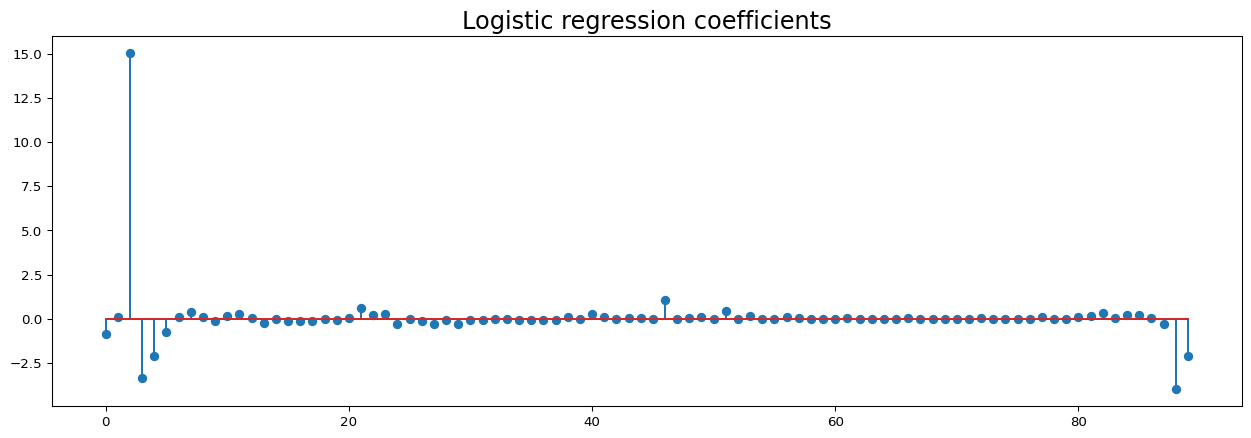

In [98]:
plt.figure(figsize=(16, 5))
plt.stem(clf.coef_[0]) # , use_line_collection=True)
plt.title('Logistic regression coefficients', fontsize=18)

In [99]:
clf.coef_[0].shape[0]

90

In [100]:
len(features_names)

92

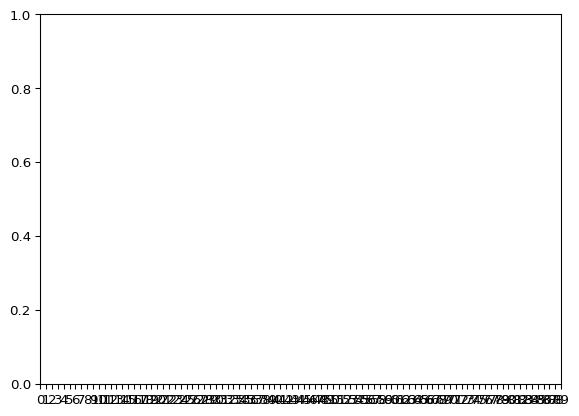

In [101]:
# We change the fontsize of minor ticks label
_ = plt.xticks(np.arange(clf.coef_[0].shape[0]), features_names, 
           rotation='vertical', fontsize=8)

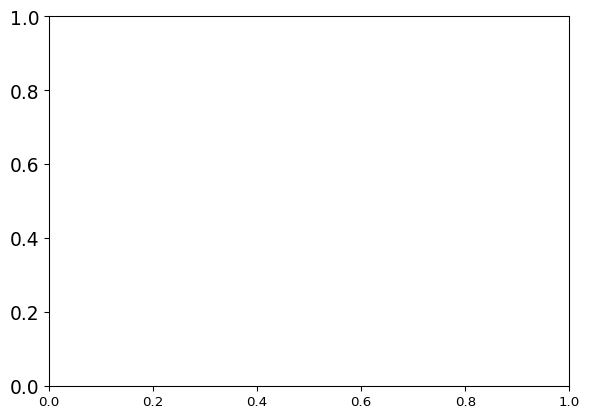

In [102]:
_ = plt.yticks(fontsize=14)

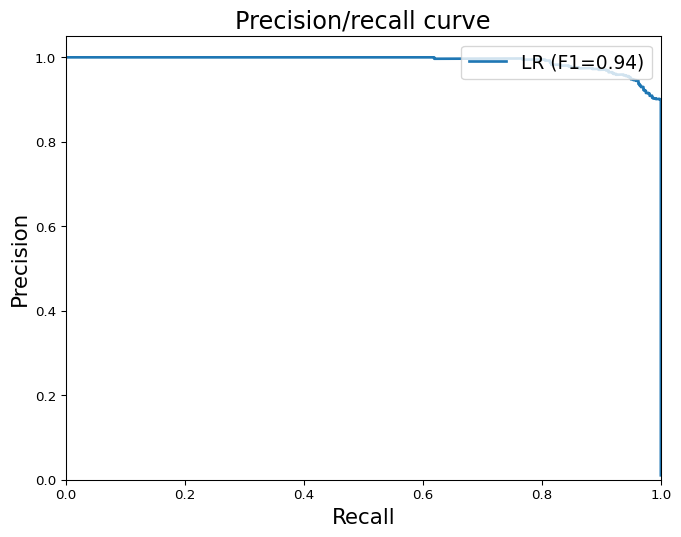

In [103]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='LR (F1=%.2f)' % f1_score(y_test, clf.predict(X_test)), lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision/recall curve', fontsize=18)
plt.legend(loc="upper right", fontsize=14)

# Analyse the tables

In [104]:
query = """
    ANALYZE TABLE db_table 
    COMPUTE STATISTICS
    FOR COLUMNS xid
"""

In [105]:
df.createOrReplaceTempView("db_table")

In [106]:
df.columns

['feature_name',
 'xid',
 'value',
 'col',
 'row',
 'keep',
 'sum_keep',
 'row_new',
 'col_new']

In [107]:
spark.sql("cache table db_table").show()

26/02/16 10:10:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/16 10:10:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 124:==================================================>     (9 + 1) / 10]26/02/16 10:10:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

++
||
++
++


In [108]:
spark.sql(query).show()

++
||
++
++


[Stage 135:>                                                        (0 + 1) / 1]                                                                                

In [109]:
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         | db_table|       true|
|         |  webdata|       true|
+---------+---------+-----------+


In [110]:
spark.stop()